In [1]:
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Fitting all wavelengths 
---
First load data in a tab separated format. The first row should be the wavelengths, the first column should be concentrations.

In [2]:
filename = os.path.join("data", "all_wavelengths_PhOH.dat")
con_N0 = 7.5 * 1e-6
end_filename ="fit_spectra_PhOH.txt"

In [3]:
## Figure out what the file looks like
with open(filename) as file:
    for i in range(2):
        print(file.readline())

--	550	549.5	549	548.5	548	547.5	547	546.5	546	545.5	545	544.5	544	543.5	543	542.5	542	541.5	541	540.5	540	539.5	539	538.5	538	537.5	537	536.5	536	535.5	535	534.5	534	533.5	533	532.5	532	531.5	531	530.5	530	529.5	529	528.5	528	527.5	527	526.5	526	525.5	525	524.5	524	523.5	523	522.5	522	521.5	521	520.5	520	519.5	519	518.5	518	517.5	517	516.5	516	515.5	515	514.5	514	513.5	513	512.5	512	511.5	511	510.5	510	509.5	509	508.5	508	507.5	507	506.5	506	505.5	505	504.5	504	503.5	503	502.5	502	501.5	501	500.5	500	499.5	499	498.5	498	497.5	497	496.5	496	495.5	495	494.5	494	493.5	493	492.5	492	491.5	491	490.5	490	489.5	489	488.5	488	487.5	487	486.5	486	485.5	485	484.5	484	483.5	483	482.5	482	481.5	481	480.5	480	479.5	479	478.5	478	477.5	477	476.5	476	475.5	475	474.5	474	473.5	473	472.5	472	471.5	471	470.5	470	469.5	469	468.5	468	467.5	467	466.5	466	465.5	465	464.5	464	463.5	463	462.5	462	461.5	461	460.5	460	459.5	459	458.5	458	457.5	457	456.5	456	455.5	455	454.5	454	453.5	453	452.5	452	451.5	451	450

Grab wavelengths from file


In [4]:
number_wavelengths = np.loadtxt(
    filename,
     skiprows=1,
    # usecols=range(1,502),
    delimiter='\t'
    ).shape[1]

In [5]:
all_wavelengths = np.loadtxt(
    filename,
     #skiprows=1,
     usecols=range(1,number_wavelengths),
    delimiter='\t'
    )[0]

Grab absorbance data

In [6]:
concentration_and_data = np.loadtxt(
    filename,
    skiprows=1,
    delimiter='\t'
)

In [7]:
## Take concentration out of data
all_data = concentration_and_data[:,1:]

## and flip the order because we had things running from large to small wavelength before
##all_data = all_data[:, -1::-1]
##all_wavelengths = all_wavelengths[-1::-1]

Define phoh as the the first column of all_data
this is the list of all concentrations of phenol

In [8]:
phoh = concentration_and_data[:,0]

Set up system of equations

In [9]:
con_X = phoh

def con_NX(K1, K2):
    
    con = (
        K1 * con_N0 * con_X
        )/(
        1 + K1*con_X + K1*K2*con_X**2.
        )
    
    return con

def con_NX2(K1, K2):
    
    con = con_NX(K1, K2) * K2 * con_X
    
    return con


def con_N(K1, K2):
    
    con = con_N0 - con_NX(K1, K2) - con_NX2(K1, K2)
    
    return con

Trimming the data

Only fit data between 320 and 500 nm

In [10]:
index_max_wavelength = np.argwhere(all_wavelengths == 500)[0,0]
index_min_wavelength = np.argwhere(all_wavelengths == 330)[0,0]

Takes all columns, but only rows between min and max wavelengths, skip every other wavelength

In [11]:
column_indicies_to_fit = range(index_max_wavelength, index_min_wavelength, 2)

trimmed_data = all_data[:, column_indicies_to_fit]

trimmed_data_wavelengths = all_wavelengths[column_indicies_to_fit]

Create vector of $\epsilon_N$ for every wavelength. 

(I am risking resusing variable names from the 3 wavelength example above...)

In [12]:
def get_eps_N_per_wavelength(data):
    return np.array([od[0] for od in data.T])/con_N0

## Define Fit Function

In [13]:
## Rewrote fit function in order to take data as arg 
def em_fit_fun(unknowns, *args):
    """ Cost function returning a vector of absorbance 
        equations at each wavelength 
        
        Args:
            unknowns 
        
        Returns: 
            vetor of length 2 +2n, where n is number of 
            wavelength points determined by length of args[0] and args[1]
        
        """
    K1, K2 = unknowns[:2]
    ## Check the length of eps_N_vec
        ## 2 * len(eps_N_vec) more unknowns
        
    ## Get data from args tuple
    data = args[0]
    eps_N_vec = args[1]
    
    ## Iterate through eps_N for each wavelength
    for i, eps_N in enumerate(eps_N_vec):
    
        ## Grab other two eps's from unknown arg (vector/list)
        ## eps_NX are odd indexed
        eps_NX = unknowns[2*(i+1)]
        ## eps_NX2s are even indexed
        eps_NX2 = unknowns[2*(i+1)+1]
        
        ## Build cost function for this wavelength 
        f = (
            eps_N * con_N(K1, K2)
            + 
            eps_NX * con_NX(K1, K2) 
            +
            eps_NX2 * con_NX2(K1, K2)
            ) - data.T[i]
        
        ## add value of cost funtion to list
        if i is 0:
            f_tot = f
        elif i is not 0:
            f_tot = np.hstack((f_tot, f))

    return f_tot

## Run the fit


In [14]:
# not_as_trimmed_data = trimmed_data[:, range(0, 300, 5)]

## Define eps_Ns 
eps_N_vec = get_eps_N_per_wavelength(trimmed_data)

##Define initial guesses 
dummy_ini_guesses = [6.03599333e+00, 4.61655475e-01] + [1*1e4, 1*1e5]*eps_N_vec.shape[0]

## Do fit
fit_multi = opt.least_squares(
    em_fit_fun, 
    dummy_ini_guesses, 
#     jac=jaco, 
#     method='lm',
    args=(trimmed_data, eps_N_vec),
    bounds=(0, np.inf),
    x_scale='jac'
)

print(f'fit results: {fit_multi.x[:2]}')


fit results: [6.39875054 1.61731232]


Grab eps_NX values at each wavelength

In [15]:
for i in range(trimmed_data_wavelengths.shape[0]):
        
        ## fit_multi.x is a vector with the two K's first 
        ##then alternating eps_NX and eps_NX2 values
        ## eps_NX are even indexed starting at 2
        eps_NX_fit = fit_multi.x[2*(i+1)]
        ## eps_NX2s are odd indexed starting at 3
        eps_NX2_fit = fit_multi.x[2*(i+1)+1]
        
         ## add values of epsNX and epsNX2 to list
        if i is 0:
            eps_NX_fit_tot = eps_NX_fit
            eps_NX2_fit_tot = eps_NX2_fit
        elif i is not 0:
            eps_NX_fit_tot = np.hstack((eps_NX_fit_tot, eps_NX_fit))
            eps_NX2_fit_tot = np.hstack((eps_NX2_fit_tot, eps_NX2_fit))
        


Save file of molar extinction coefficient curves for TAHz-PhOH and TAHz-PhOH2

In [16]:
fit_spectra = np.asarray([ trimmed_data_wavelengths, eps_N_vec, eps_NX_fit_tot, eps_NX2_fit_tot ])
np.savetxt(end_filename, fit_spectra, delimiter=',')

Plotting the fit and data at select wavelengths

In [17]:
def Absorbance_per_wavelength(params, *args):
    """ reutrns array where each row is a list of absorbance 
        values per concentration (column index).
        """
    
    ## get vec of eps_N from args to count wavelengths
    eps_N_vec = args[1]
    n_wavelengths = eps_N_vec.shape[0]
    ## get data 
    data = args[0]
    
    ## get number of concentrations from data, should be number of rows
    num_concentrations = data.shape[0]
    
    
    em_fit_array = em_fit_fun(params, *args).reshape(
        (n_wavelengths, num_concentrations))
    
    absorb = em_fit_array + data.T
    
    return absorb

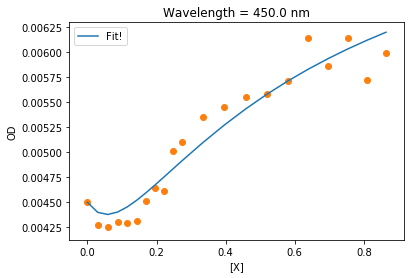

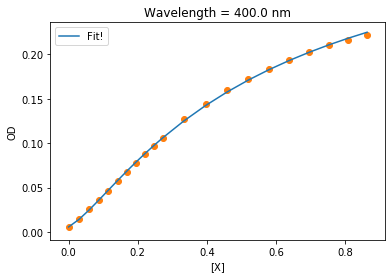

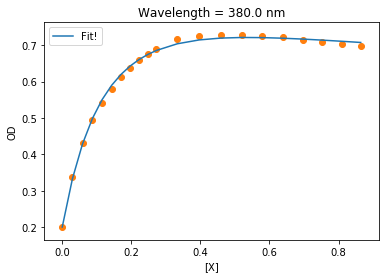

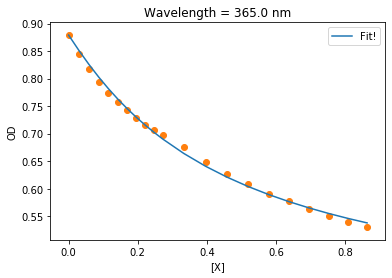

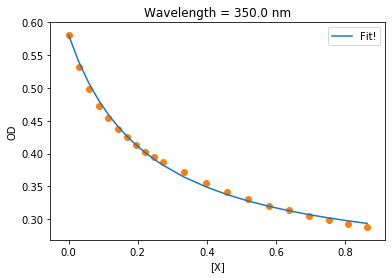

In [18]:
def find_aprox_wavelength_idx(wl, wl_array):
    """ Finds the index of value in 'wl_array' closest to wl 
        """
    return np.argmin(np.abs(wl_array-wl))
    

## Define wavelengths to plot
wavelength_indicies_to_plot = [
    find_aprox_wavelength_idx(450, trimmed_data_wavelengths),
    find_aprox_wavelength_idx(400, trimmed_data_wavelengths),
    find_aprox_wavelength_idx(380, trimmed_data_wavelengths),
    find_aprox_wavelength_idx(365, trimmed_data_wavelengths),
    find_aprox_wavelength_idx(350, trimmed_data_wavelengths),
#     np.argwhere(trimmed_data_wavelengths == 400)[0,0],
#     np.argwhere(trimmed_data_wavelengths == 380)[0,0],
#     np.argwhere(trimmed_data_wavelengths == 365)[0,0],
#     np.argwhere(trimmed_data_wavelengths == 350)[0,0],
    ]

## Iterate through wavelength indicies we want to plot
for i in wavelength_indicies_to_plot:
    
    ## Initialize figure 
    plt.figure()
    
#     ## Plot initial guess
#     plt.plot(
#         con_X, 
#         Absorbance_per_wavelength(dummy_ini_guesses, trimmed_data, eps_N_vec)[i], 
#         ls='--',
#         c='k',
#         label='initial guess')

    ## Plot fit results
    plt.plot(
        con_X, 
        Absorbance_per_wavelength(fit_multi.x, trimmed_data, eps_N_vec)[i], 
        label='Fit!')
    
    ## Plot data
    plt.scatter(con_X, trimmed_data.T[i,:], c='C1')

    plt.title(f'Wavelength = {trimmed_data_wavelengths[i]:.1f} nm')
    plt.xlabel('[X]')
    plt.ylabel('OD')    
    plt.legend()



In [19]:
print(wavelength_indicies_to_plot
    )

[50, 100, 120, 135, 150]
